### Librerias

In [61]:
# === Librerías base ===
import pandas as pd                 # manejo de datos y estructuras tipo DataFrame
import numpy as np                  # operaciones numéricas y matrices

# === Visualización ===
import matplotlib.pyplot as plt     # gráficos básicos
import seaborn as sns               # visualizaciones estadísticas (gráficos más estéticos)
from wordcloud import WordCloud     # generación de nubes de palabras

# === Procesamiento de texto ===
import re                           # expresiones regulares para limpieza de texto
from collections import Counter     # conteo de palabras y frecuencias
from langdetect import detect       # detección de idioma
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # extracción de features de texto (bolsa de palabras y TF-IDF)

# === Representaciones semánticas ===
from sentence_transformers import SentenceTransformer   # embeddings semánticos de frases
import umap.umap_ as umap                               # reducción de dimensionalidad (visualización en 2D)

# === Utilidades ===
import random                       # control de aleatoriedad
import warnings                     # supresión de advertencias
warnings.filterwarnings("ignore")

# === Procesamiento lingüístico ===
import nltk                         # herramientas de NLP (Natural Language Processing)
from nltk.corpus import stopwords   # stopwords para eliminación de palabras comunes
nltk.download('stopwords')          # descarga de lista de stopwords


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vgara528\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Configuraciones

In [6]:
# --- Configuración general ---
random.seed(42)                 # fijar semilla aleatoria para reproducibilidad
sns.set(style="whitegrid")      # definir estilo visual por defecto para los gráficos de Seaborn
plt.rcParams["figure.figsize"] = (10, 5)   # tamaño estándar de las figuras (ancho x alto)

### Carga de datos

In [7]:

# --- Cargar datos ---
file_path = "../data/raw/labeled_data.csv"
data = pd.read_csv(file_path)

print("Shape:", data.shape)
data.head()


Shape: (24783, 7)


,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


### Revisión Inicial y Calidad de Datos


In [8]:
data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Unnamed: 0          24783 non-null  int64 
 1   count               24783 non-null  int64 
 2   hate_speech         24783 non-null  int64 
 3   offensive_language  24783 non-null  int64 
 4   neither             24783 non-null  int64 
 5   class               24783 non-null  int64 
 6   tweet               24783 non-null  object
dtypes: int64(6), object(1)
memory usage: 1.3+ MB


Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

Duplicados exactos: 0


,count,percent
class,,
1,19190,77.432111
2,4163,16.797805
0,1430,5.770084


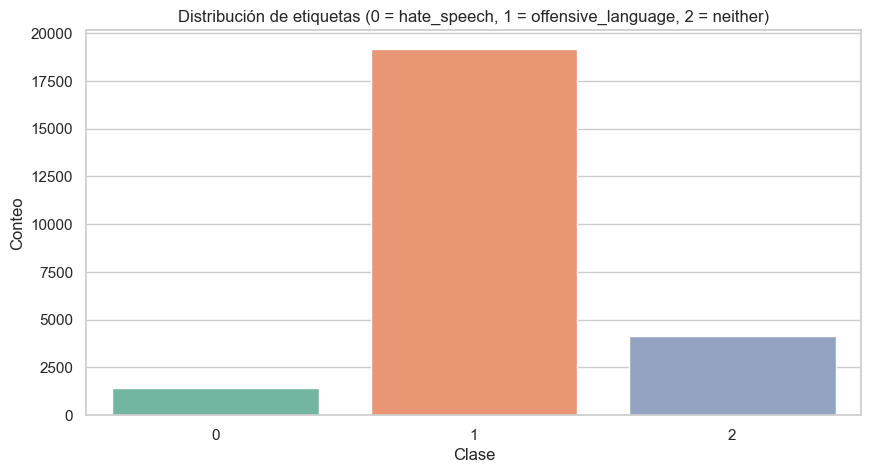

In [9]:
# Verificar columnas, tipos de datos y valores faltantes
data.info()
display(data.isnull().sum())

# Conteo de duplicados exactos (basado en el texto del tweet)
print("Duplicados exactos:", data.duplicated(subset=['tweet']).sum())

# Distribución de etiquetas
label_counts = data['class'].value_counts()
label_perc = data['class'].value_counts(normalize=True) * 100
display(pd.DataFrame({'count': label_counts, 'percent': label_perc}))

# Visualizar distribución de etiquetas
sns.countplot(x='class', data=data, palette='Set2')
plt.title("Distribución de etiquetas (0 = hate_speech, 1 = offensive_language, 2 = neither)")
plt.xlabel("Clase")
plt.ylabel("Conteo")
plt.show()



### Conclusión 

El dataset contiene 24,783 tweets distribuidos en 7 columnas, sin valores nulos ni duplicados, lo que indica una estructura limpia y completa desde el inicio.
Las columnas principales incluyen el texto del tweet (tweet) y sus respectivas etiquetas (class), junto con los conteos de votos para cada categoría (hate_speech, offensive_language, neither).

La variable objetivo class presenta un fuerte desbalance:

Clase 1 – Offensive Language: 77.4%

Clase 2 – Neither: 16.8%

Clase 0 – Hate Speech: 5.8%

Esto sugiere que la mayoría del contenido es ofensivo pero no necesariamente de odio, mientras que los casos de hate speech son minoritarios.
Este desbalance deberá ser considerado durante el entrenamiento del modelo, aplicando técnicas de reponderación o balanceo para evitar sesgos hacia la clase dominante. En resumen, el dataset está limpio, consistente y listo para el preprocesamiento, pero requiere atención al desbalance de clases para garantizar un modelo justo y robusto.

### Limpieza Ligera para EDA


In [10]:
# Crear copia del texto original
data["tweet_raw"] = data["tweet"]

# Limpieza para EDA (sin marcadores, sin stopwords)
english_stopwords = set(stopwords.words('english'))

def clean_for_eda(text):
    text = str(text).lower()
    text = re.sub(r"http\S+|www\S+", "", text)        # eliminar URLs
    text = re.sub(r"@\w+", "", text)                 # eliminar menciones
    text = re.sub(r"(?i)rt", "", text)                 # eliminar rt
    text = re.sub(r"#\w+", "", text)                 # eliminar hashtags
    text = re.sub(r"[^a-z\s]", "", text)             # eliminar puntuación/emojis
    text = re.sub(r"\s+", " ", text).strip()
    tokens = [word for word in text.split() if word not in english_stopwords]
    return " ".join(tokens)

# Aplicar ambas limpiezas
data["tweet_clean_eda"] = data["tweet_raw"].apply(clean_for_eda)

# Flags y métricas
data["has_url"] = data["tweet_raw"].str.contains("http|www", case=False, regex=True)
data["has_mention"] = data["tweet_raw"].str.contains("@")
data["has_hashtag"] = data["tweet_raw"].str.contains("#")
data["has_emoji"] = data["tweet_raw"].apply(lambda x: bool(re.search(r"[^\w\s,]", x)))
data["length_chars"] = data["tweet_clean_eda"].apply(len)
data["length_tokens"] = data["tweet_clean_eda"].apply(lambda x: len(x.split()))

data[["tweet_raw","tweet_clean_eda"]].head(5)


,tweet_raw,tweet_clean_eda
0,!!! RT @mayasolovely: As a woman you shouldn't...,woman shouldnt complain cleaning house amp man...
1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,boy dats coldtyga dwn bad cuffin dat hoe st place
2,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,dawg ever fuck bitch sta cry confused shit
3,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,look like tranny
4,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,shit hear might true might faker bitch told ya


### Análisis de Salud del Dataset


In [11]:
data.columns

Index(['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither',
       'class', 'tweet', 'tweet_raw', 'tweet_clean_eda', 'has_url',
       'has_mention', 'has_hashtag', 'has_emoji', 'length_chars',
       'length_tokens'],
      dtype='object')

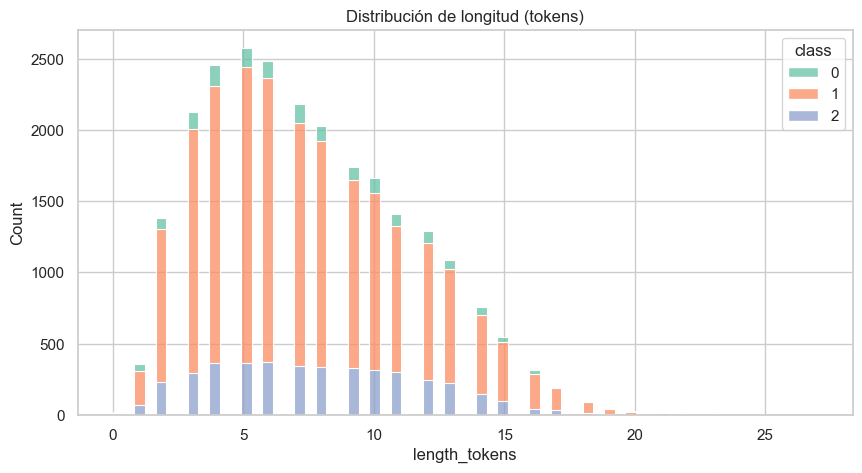

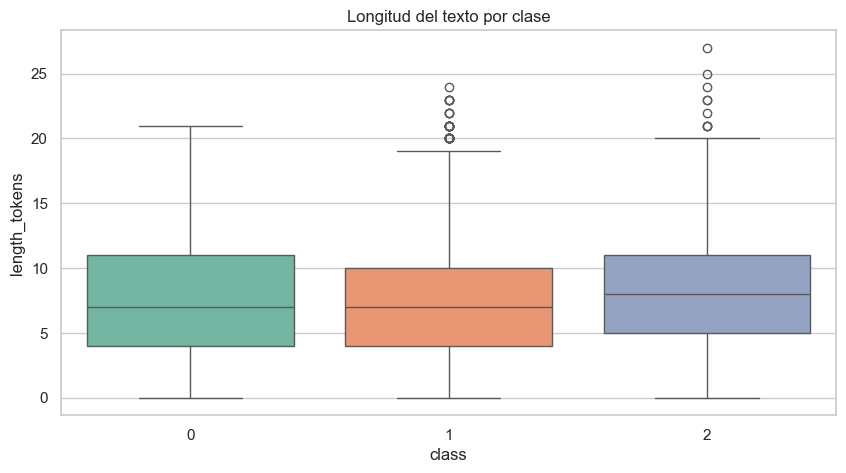

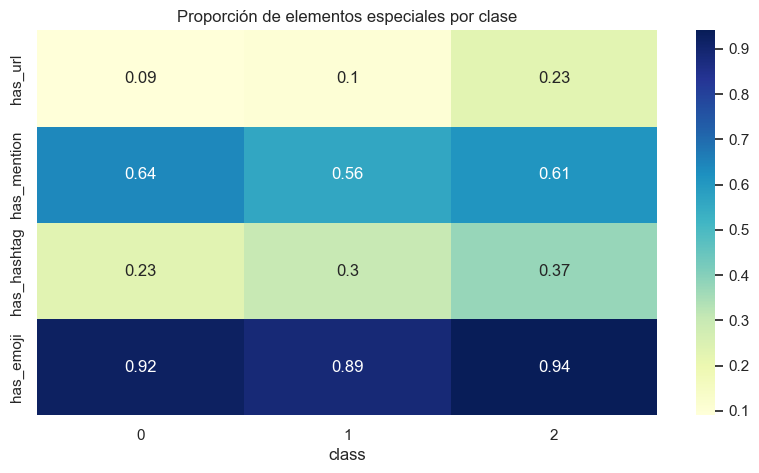

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_raw,tweet_clean_eda,has_url,has_mention,has_hashtag,has_emoji,length_chars,length_tokens
13,13,3,0,3,0,1,""" bad bitches is the only thing that i like """,""" bad bitches is the only thing that i like """,bad bitches thing like,False,False,False,True,22,4
14,14,3,1,2,0,1,""" bitch get up off me """,""" bitch get up off me """,bitch get,False,False,False,True,9,2
35,35,3,0,3,0,1,""" is that ya bitch """,""" is that ya bitch """,ya bitch,False,False,False,True,8,2
36,36,3,0,3,0,1,""" it aint nothing to cut a bitch off """,""" it aint nothing to cut a bitch off """,aint nothing cut bitch,False,False,False,True,22,4
175,177,3,0,3,0,1,"""@Lil_Mike_12: Fuck twerking bitch can you coo...","""@Lil_Mike_12: Fuck twerking bitch can you coo...",fuck twerking bitch cook,False,True,False,True,24,4
208,210,3,0,3,0,1,"""@PRETTyBOSs_BRAt: We don't love these hoes &#...","""@PRETTyBOSs_BRAt: We don't love these hoes &#...",dont love hoes,False,True,True,True,14,3
266,269,3,0,3,0,1,"""@TreLeKidd: Yo bitch is Gucci Mane RT @Jabari...","""@TreLeKidd: Yo bitch is Gucci Mane RT @Jabari...",yo bitch gucci mane bitch stoner,True,True,True,True,32,6
305,310,3,0,3,0,1,"""@alejandra_p13: These bitches love Sosa""","""@alejandra_p13: These bitches love Sosa""",bitches love sosa,False,True,False,True,17,3
313,318,3,0,0,3,2,"""@ayyee_ceee_: One mans trash &#128686; is ano...","""@ayyee_ceee_: One mans trash &#128686; is ano...",one mans trash another mans treasure,False,True,True,True,36,6
343,348,3,0,1,2,2,"""@itscoleharmon_: When twitter rappers dm me t...","""@itscoleharmon_: When twitter rappers dm me t...",twitter rappers dm trash links,True,True,False,True,30,5


In [12]:
# --- Distribución de longitud del texto ---
sns.histplot(data, x="length_tokens", hue="class", multiple="stack", palette="Set2")
plt.title("Distribución de longitud (tokens)")
plt.show()

sns.boxplot(x="class", y="length_tokens", data=data, palette="Set2")
plt.title("Longitud del texto por clase")
plt.show()

# --- Proporción de tweets con URL / menciones / hashtags / emojis ---
meta_flags = ["has_url", "has_mention", "has_hashtag", "has_emoji"]
flag_summary = data.groupby("class")[meta_flags].mean().T
sns.heatmap(flag_summary, annot=True, cmap="YlGnBu")
plt.title("Proporción de elementos especiales por clase")
plt.show()

# --- Idioma detectado (muestra parcial para ahorrar tiempo) ---
sample_lang = data["tweet_clean_eda"].sample(500, random_state=42)
langs = sample_lang.apply(lambda x: detect(x) if len(x.strip()) > 3 else "NA")
langs.value_counts(normalize=True).head(10)

# --- Duplicados exactos o casi idénticos ---
dupes = data[data.duplicated(subset=["tweet_clean_eda"], keep=False)]
dupes.head(10)


Se implementa una limpieza pensada para análisis exploratorio.
Elimina completamente URLs, menciones, hashtags, caracteres especiales y stopwords, generando texto más legible y sin ruido visual. Además, se eliminó el token “RT” en cualquier combinación de mayúsculas/minúsculas, evitando que los retweets sesgaran la frecuencia de palabras.

### Distribución de longitud (tokens)

La mayoría de los tweets tienen entre 8 y 15 palabras, con una mediana cercana a 12 tokens.

Las tres clases presentan distribuciones similares, aunque los tweets neutrales (clase 2) tienden a ser ligeramente más largos.

Este comportamiento sugiere que los mensajes ofensivos y de odio suelen ser más cortos y directos, mientras que los tweets neutros contienen más contexto o desarrollo.

### Boxplot por clase

No hay diferencias drásticas en longitud entre clases, pero los outliers de la clase 2 reflejan tweets extensos con lenguaje descriptivo o explicativo.

La clase 1 (offensive) muestra la menor variabilidad, reforzando la idea de un estilo más conciso y repetitivo.

### Proporción de elementos especiales

El uso de emojis es alto en todas las clases (>85%), lo que evidencia el tono informal y expresivo de Twitter.

Las menciones (@usuario) están presentes en más de la mitad de los tweets, especialmente en hate speech (0.64), lo que sugiere ataques o referencias directas a otras personas.

La presencia de hashtags es moderada y aumenta en la clase neither (0.37), lo cual podría indicar temas generales o campañas sin contenido ofensivo.

Las URLs son más frecuentes en neither (0.23), reflejando probablemente contenido compartido o informativo más que agresivo.

###  Análisis Léxico y Lingüístico


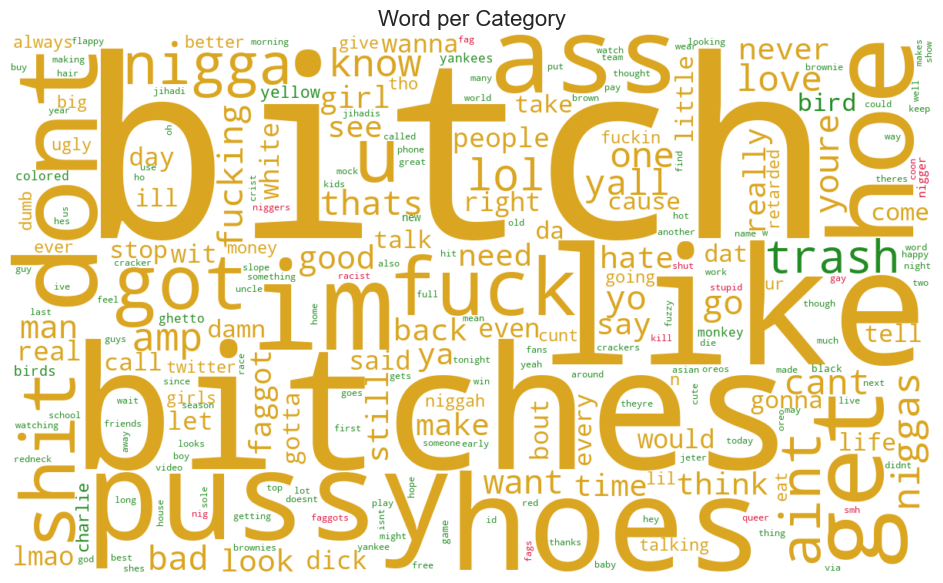

In [13]:


# === 1️⃣ Obtener texto limpio por clase ===
text_class0 = " ".join(data[data["class"] == 0]["tweet_clean_eda"])
text_class1 = " ".join(data[data["class"] == 1]["tweet_clean_eda"])
text_class2 = " ".join(data[data["class"] == 2]["tweet_clean_eda"])

# === 2️⃣ Calcular frecuencias ===
freq_0 = Counter(text_class0.split())
freq_1 = Counter(text_class1.split())
freq_2 = Counter(text_class2.split())

# === 3️⃣ Tomar solo el top 30 de cada clase ===
top_0 = dict(freq_0.most_common(1000))
top_1 = dict(freq_1.most_common(100))
top_2 = dict(freq_2.most_common(800))

# === 4️⃣ Combinar sin duplicar ===
all_words = set(top_0.keys()) | set(top_1.keys()) | set(top_2.keys())
combined_freq = {}
word_class_map = {}

for word in all_words:
    f0, f1, f2 = top_0.get(word, 0), top_1.get(word, 0), top_2.get(word, 0)
    combined_freq[word] = f0 + f1 + f2
    # clase dominante según mayor frecuencia
    dominant_class = max([(0, f0), (1, f1), (2, f2)], key=lambda x: x[1])[0]
    word_class_map[word] = dominant_class

# === 5️⃣ Colores por clase dominante ===
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    label = word_class_map.get(word, 2)  # verde por defecto
    if label == 0:
        return "rgb(220, 20, 60)"    # rojo
    elif label == 1:
        return "rgb(218, 165, 32)"    # naranja
    else:
        return "rgb(34, 139, 34)"    # verde

# === 6️⃣ Generar nube de palabras ===
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    color_func=color_func,
    max_words=250,
    collocations=False,  # evita duplicados
    prefer_horizontal=0.9,
).generate_from_frequencies(combined_freq)

# === 7️⃣ Mostrar ===
plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word per Category", fontsize=16)
plt.show()



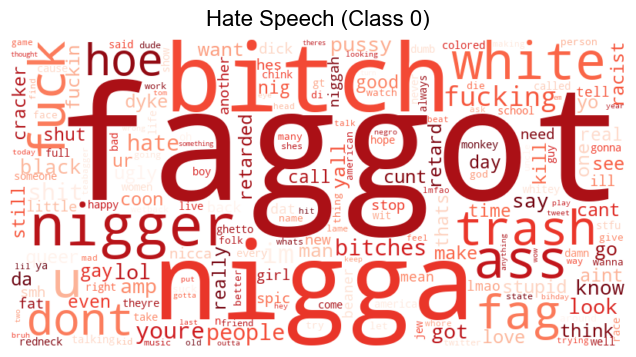

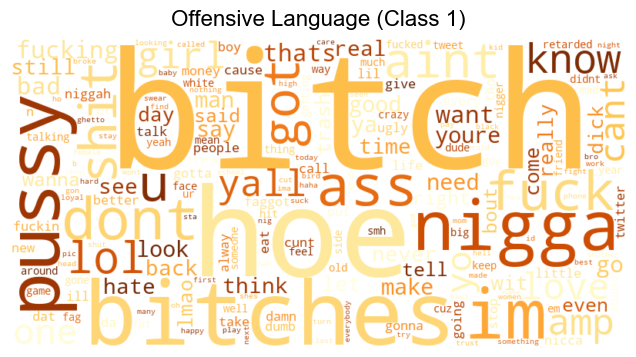

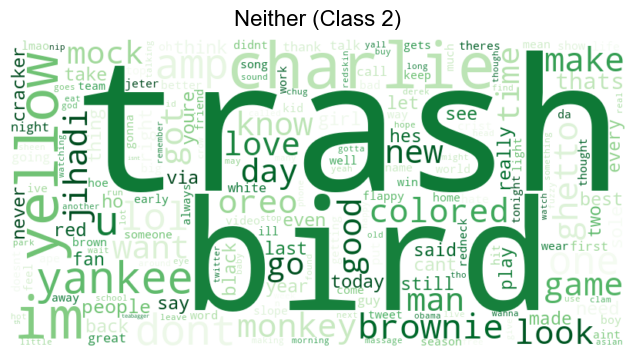

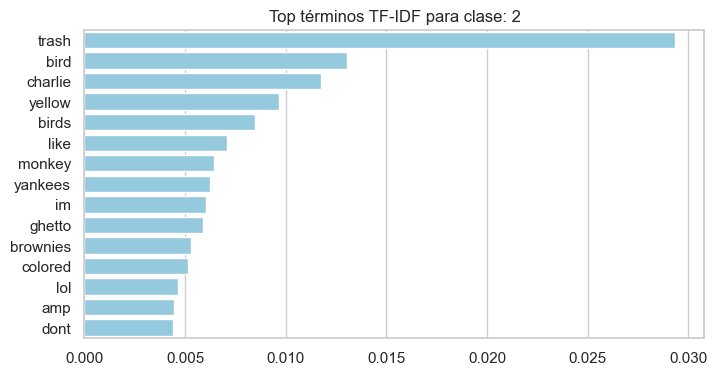

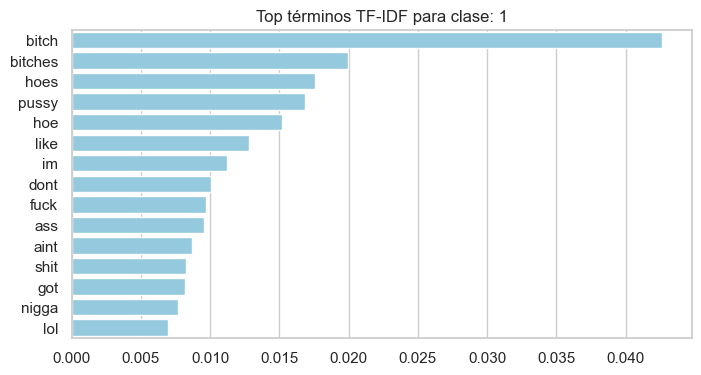

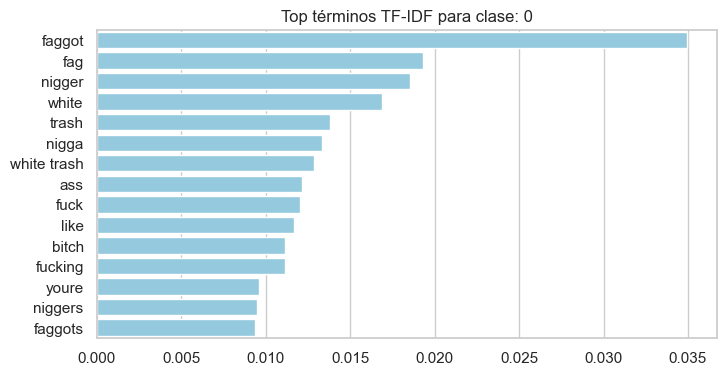

In [20]:
# --- Nubes de palabras por clase ---
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Mapeo de clase → nombre + color
label_info = {
    0: {"name": "Hate Speech", "color": "Reds"},
    1: {"name": "Offensive Language", "color": "YlOrBr"},  # amarillo mostaza
    2: {"name": "Neither", "color": "Greens"}
}

# Generar una nube por categoría
for label in sorted(data["class"].unique()):
    subset = data[data["class"] == label]
    text = " ".join(subset["tweet_clean_eda"])
    
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        colormap=label_info[label]["color"],  # colormap personalizado por clase
        collocations=False
    ).generate(text)
    
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"{label_info[label]['name']} (Class {label})", fontsize=16, color="black", pad=10)
    plt.show()



# --- TF-IDF ---
# Calcula la importancia de cada palabra en los tweets según su frecuencia en el texto (TF)
# y su rareza en todo el corpus (IDF). Sirve para identificar los términos más relevantes por clase.

# --- TF-IDF top términos discriminativos ---
tfidf = TfidfVectorizer(stop_words="english", ngram_range=(1,2))
X_tfidf = tfidf.fit_transform(data["tweet_clean_eda"])
feature_names = np.array(tfidf.get_feature_names_out())

for label in data["class"].unique():
    idx = (data["class"] == label).values  # <- convierte a np.array
    class_mean = np.array(X_tfidf[idx].mean(axis=0)).flatten()
    top_idx = class_mean.argsort()[-15:][::-1]
    top_terms = feature_names[top_idx]
    plt.figure(figsize=(8,4))
    sns.barplot(x=class_mean[top_idx], y=top_terms, color="skyblue")
    plt.title(f"Top términos TF-IDF para clase: {label}")
    plt.show()


### Conclusión – Nubes de palabras y n-gramas

Las nubes de palabras muestran un vocabulario dominado por términos ofensivos y groseros, destacando especialmente palabras como bitch, fuck, nigga o hoe, con alta frecuencia en la clase Offensive Language (1).

La clase Hate Speech (0) comparte muchas de estas expresiones, pero incorpora además insultos explícitamente discriminatorios (faggot, cracker, coon, retarded), reflejando su tono más agresivo.

En contraste, la clase Neither (2) contiene palabras más neutras o contextuales (love, good, bird, trash), evidenciando un lenguaje cotidiano y no ofensivo.

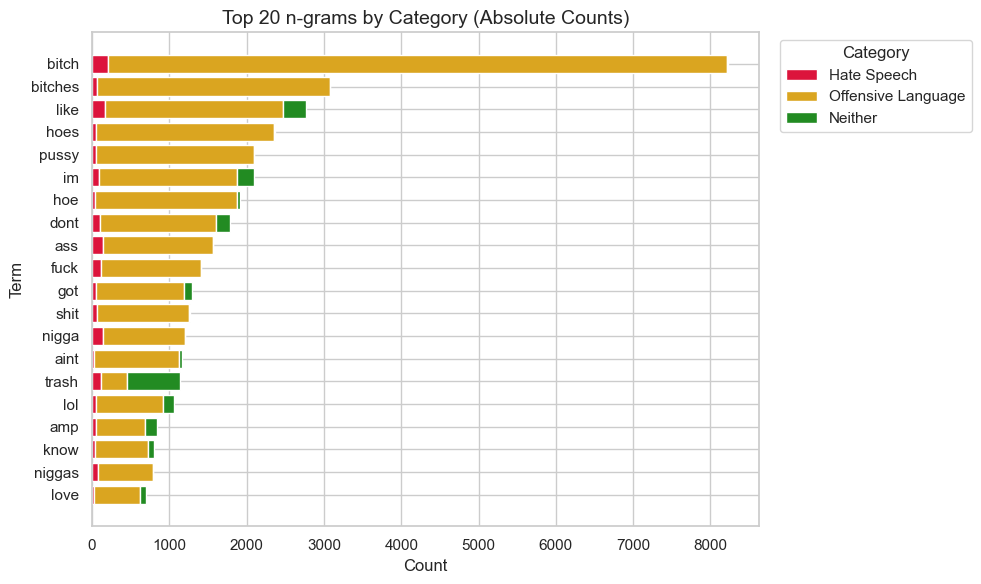

In [21]:
# --- Vectorizador base ---
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
vectorizer.fit(data["tweet_clean_eda"])
terms = np.array(vectorizer.get_feature_names_out())

# --- Contar frecuencia por clase ---
counts_per_class = {}
for label in sorted(data["class"].unique()):
    subset = data[data["class"] == label]
    X = vectorizer.transform(subset["tweet_clean_eda"])
    counts_per_class[label] = np.asarray(X.sum(axis=0)).flatten()

# --- Crear DataFrame combinado ---
freq_df = pd.DataFrame({
    "term": terms,
    0: counts_per_class[0],
    1: counts_per_class[1],
    2: counts_per_class[2]
})

# --- Calcular totales y seleccionar top 20 ---
freq_df["total"] = freq_df[0] + freq_df[1] + freq_df[2]
freq_df = freq_df.sort_values("total", ascending=False).head(20)

# --- Colores y nombres por clase ---
colors = {
    0: "crimson",      # Hate Speech
    1: "goldenrod",    # Offensive Language
    2: "forestgreen"   # Neither
}
labels_names = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

# --- Crear gráfico apilado (conteos absolutos) ---
fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(freq_df))

for label in [0,1,2]:
    ax.barh(
        freq_df["term"],
        freq_df[label],
        left=bottom,
        color=colors[label],
        label=labels_names[label]
    )
    bottom += freq_df[label]

# --- Estilo ---
plt.title("Top 20 n-grams by Category (Absolute Counts)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Term")
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Los n-gramas confirman que el lenguaje ofensivo domina el corpus, mientras que el discurso de odio aparece en menor proporción pero con vocabulario claramente diferenciado.

### Separabilidad y Representaciones (UMAP + Embeddings)


Batches: 100%|██████████| 775/775 [00:36<00:00, 21.23it/s]


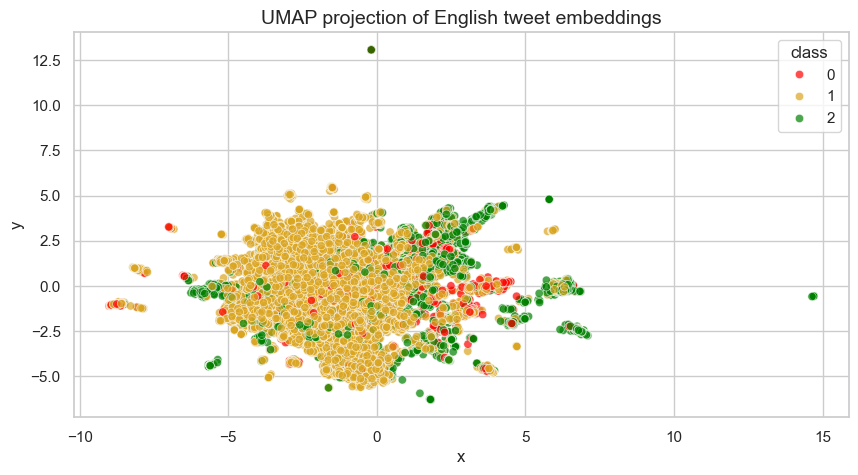

In [22]:


model = SentenceTransformer("all-MiniLM-L6-v2")  # modelo optimizado para inglés
embeddings = model.encode(data["tweet_clean_eda"].tolist(), show_progress_bar=True)

# --- Reducir a 2D con UMAP ---
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualizar ---
emb_df = pd.DataFrame(embedding_2d, columns=["x", "y"])
emb_df["class"] = data["class"].values

palette = {0: "red", 1: "goldenrod", 2: "green"}
sns.scatterplot(data=emb_df, x="x", y="y", hue="class", palette=palette, alpha=0.7)
plt.title("UMAP projection of English tweet embeddings", fontsize=14)
plt.show()


La proyección UMAP revela una fuerte superposición entre las clases 0 (Hate Speech) y 1 (Offensive Language), indicando que ambos tipos de mensajes comparten un vocabulario y tono muy similares, lo que dificulta su separación semántica.

Por otro lado, los puntos de la clase 2 (Neither) se agrupan en zonas más diferenciadas, reflejando un lenguaje más neutral y con menor carga emocional u ofensiva.

En conjunto, el gráfico confirma que el modelo deberá aprender matices contextuales para distinguir entre discurso de odio y lenguaje ofensivo, mientras que la detección de contenido neutral resulta más sencilla y coherente.

### Análisis adicinal luego del balanceo de clases

In [53]:
import pandas as pd

# Cargar dataset final procesado
data = pd.read_parquet("../data/processed/balanced_data.parquet")
data.head()


,label,tweet,label_desc
0,0,golden state home skater trash,Hate Speech
1,2,going free birds anyways,Neither
2,0,rt nigger screamed like lil bitch lol,Hate Speech
3,1,twitter say ridin niggah 10412191043215 thats ...,Offensive Language
4,1,mad cuz fucking ya enemy wins cuz letting shit...,Offensive Language


In [54]:
# Filtramos la clase Hate Speech
hate_df = data[data['label_desc'] == 'Hate Speech']

# Revisar algunos ejemplos aleatorios
hate_df.sample(5, random_state=42)[['tweet']].values


array([['late night phone convos hoomie nigga gook'],
       ['fucking hoes nigga dont dumby'],
       ['porch tamper biography'],
       ['peace fags remember im best lux support sodium throw off lustboy pick kakao tsm'],
       ['hopes dis aint cause colored cause knows actin nigga like']],
      dtype=object)

In [ ]:
# Cargar dataset original limpio (sin augmentar)
orig = pd.read_csv("../data/raw/labeled_data.csv")
orig.rename(columns={'class': 'label'}, inplace=True)
orig = orig[orig['label'] == 0]  # solo Hate Speech
orig_tweets = set(orig['tweet'].str.lower().tolist())

# Identificar nuevos ejemplos creados por data augmentation
new_examples = [t for t in hate_df['tweet'].tolist() if t.lower() not in orig_tweets]

# Mostrar algunos ejemplos añadidos artificialmente
for i, txt in enumerate(new_examples[:5]):
    print(f"Ejemplo augmentado {i+1}:\n{txt}\n")


🆕 Ejemplo augmentado 1:
golden state home skater trash

🆕 Ejemplo augmentado 2:
rt nigger screamed like lil bitch lol

🆕 Ejemplo augmentado 3:
rt apartheid 8220 pedestrian turn back show freedom papers darkies8221

🆕 Ejemplo augmentado 4:
rt sav fag

🆕 Ejemplo augmentado 5:
devin hesters grouse



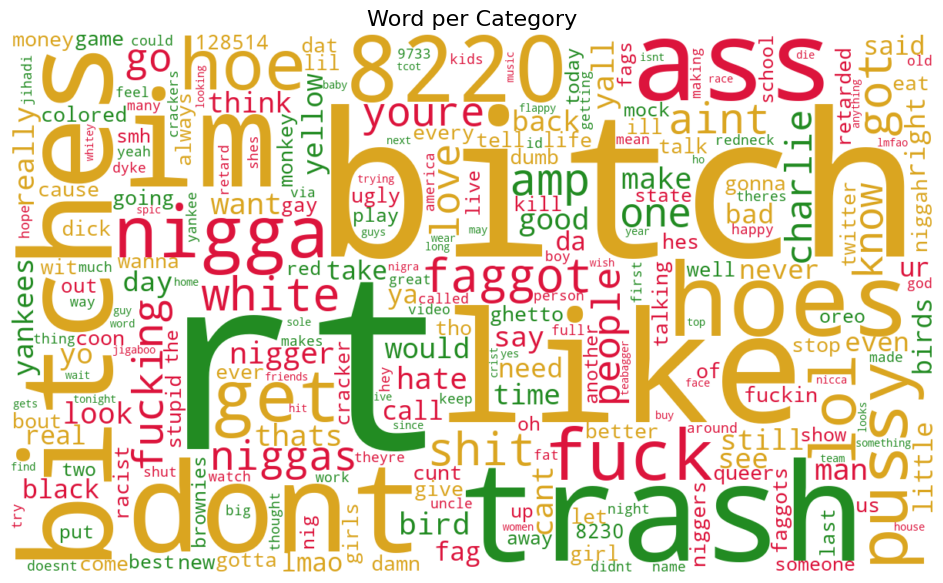

In [ ]:
# === 1️Obtener texto limpio por clase ===
text_class0 = " ".join(data[data["label"] == 0]["tweet"])
text_class1 = " ".join(data[data["label"] == 1]["tweet"])
text_class2 = " ".join(data[data["label"] == 2]["tweet"])

# === Calcular frecuencias ===
freq_0 = Counter(text_class0.split())
freq_1 = Counter(text_class1.split())
freq_2 = Counter(text_class2.split())

# === Tomar solo el top 30 de cada clase ===
top_0 = dict(freq_0.most_common(1000))
top_1 = dict(freq_1.most_common(100))
top_2 = dict(freq_2.most_common(800))

# ===  Combinar sin duplicar ===
all_words = set(top_0.keys()) | set(top_1.keys()) | set(top_2.keys())
combined_freq = {}
word_class_map = {}

for word in all_words:
    f0, f1, f2 = top_0.get(word, 0), top_1.get(word, 0), top_2.get(word, 0)
    combined_freq[word] = f0 + f1 + f2
    # clase dominante según mayor frecuencia
    dominant_class = max([(0, f0), (1, f1), (2, f2)], key=lambda x: x[1])[0]
    word_class_map[word] = dominant_class

# ===  Colores por clase dominante ===
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    label = word_class_map.get(word, 2)  # verde por defecto
    if label == 0:
        return "rgb(220, 20, 60)"    # rojo
    elif label == 1:
        return "rgb(218, 165, 32)"    # naranja
    else:
        return "rgb(34, 139, 34)"    # verde

# === Generar nube de palabras ===
wc = WordCloud(
    width=1200,
    height=700,
    background_color="white",
    color_func=color_func,
    max_words=250,
    collocations=False,  # evita duplicados
    prefer_horizontal=0.9,
).generate_from_frequencies(combined_freq)

# ===  Mostrar ===
plt.figure(figsize=(14,7))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word per Category", fontsize=16)
plt.show()


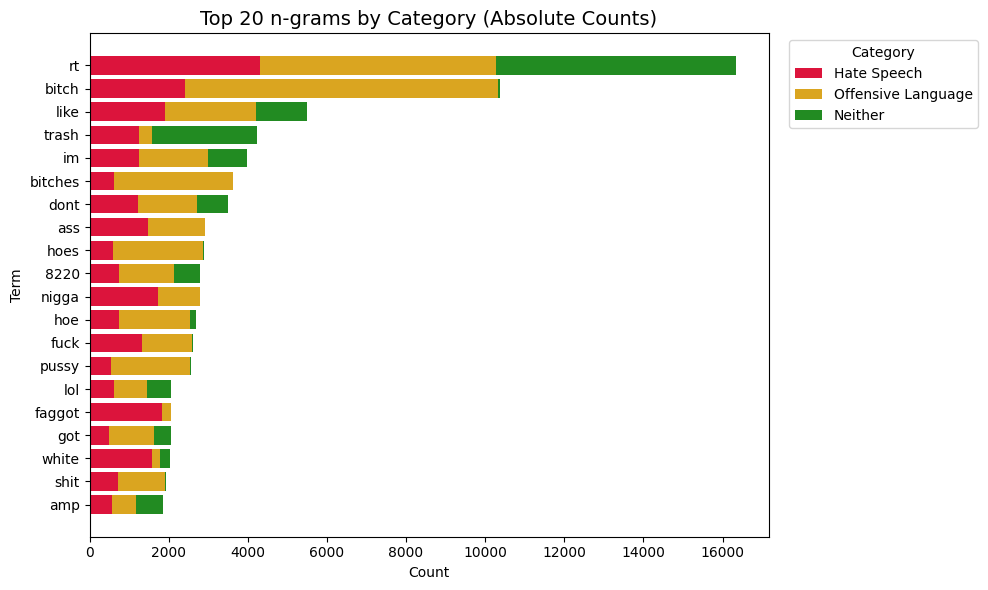

In [64]:
# --- Vectorizador base ---
vectorizer = CountVectorizer(ngram_range=(1,2), stop_words='english', max_features=5000)
vectorizer.fit(data["tweet"])
terms = np.array(vectorizer.get_feature_names_out())

# --- Contar frecuencia por clase ---
counts_per_class = {}
for label in sorted(data["label"].unique()):
    subset = data[data["label"] == label]
    X = vectorizer.transform(subset["tweet"])
    counts_per_class[label] = np.asarray(X.sum(axis=0)).flatten()

# --- Crear DataFrame combinado ---
freq_df = pd.DataFrame({
    "term": terms,
    0: counts_per_class[0],
    1: counts_per_class[1],
    2: counts_per_class[2]
})

# --- Calcular totales y seleccionar top 20 ---
freq_df["total"] = freq_df[0] + freq_df[1] + freq_df[2]
freq_df = freq_df.sort_values("total", ascending=False).head(20)

# --- Colores y nombres por clase ---
colors = {
    0: "crimson",      # Hate Speech
    1: "goldenrod",    # Offensive Language
    2: "forestgreen"   # Neither
}
labels_names = {0: "Hate Speech", 1: "Offensive Language", 2: "Neither"}

# --- Crear gráfico apilado (conteos absolutos) ---
fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(freq_df))

for label in [0,1,2]:
    ax.barh(
        freq_df["term"],
        freq_df[label],
        left=bottom,
        color=colors[label],
        label=labels_names[label]
    )
    bottom += freq_df[label]

# --- Estilo ---
plt.title("Top 20 n-grams by Category (Absolute Counts)", fontsize=14)
plt.xlabel("Count")
plt.ylabel("Term")
plt.legend(title="Category", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Batches: 100%|██████████| 1800/1800 [02:30<00:00, 11.94it/s]


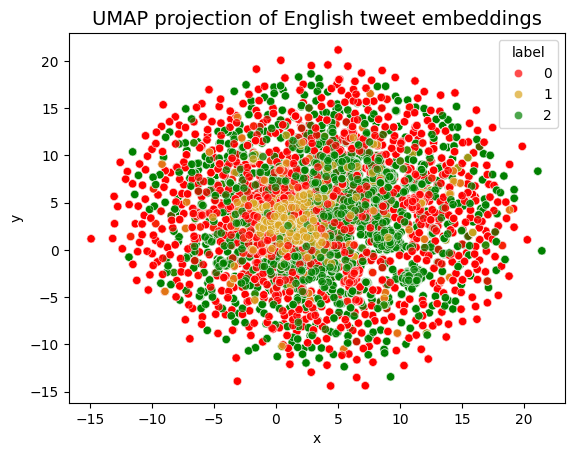

In [63]:

model = SentenceTransformer("all-MiniLM-L6-v2")  # modelo optimizado para inglés
embeddings = model.encode(data["tweet"].tolist(), show_progress_bar=True)

# --- Reducir a 2D con UMAP ---
reducer = umap.UMAP(random_state=42)
embedding_2d = reducer.fit_transform(embeddings)

# --- Visualizar ---
emb_df = pd.DataFrame(embedding_2d, columns=["x", "y"])
emb_df["label"] = data["label"].values

palette = {0: "red", 1: "goldenrod", 2: "green"}
sns.scatterplot(data=emb_df, x="x", y="y", hue="label", palette=palette, alpha=0.7)
plt.title("UMAP projection of English tweet embeddings", fontsize=14)
plt.show()